# 15. Voronoi Tessellation

In some of the earlier lessons we dicussed how to conduct *proximity analyses* using buffer polygons. We looked at how accessible schools were via bike paths in Berkeley. Instead of using a buffers drawn at differnt radii around our locations or objects of interest, we could also use something called a **Voronoi diagram**.

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/5/54/Euclidean_Voronoi_diagram.svg/800px-Euclidean_Voronoi_diagram.svg.png' style="width: 400px;">

As seen above, we have a bunch of **Voronoi cells** that are delineated by encompassing all locations that are closest to our point of interest than any other points. 

In this notebook, we'll experiment with making these type of diagrams in Python.

In [32]:
import pandas as pd
import geopandas as gpd
import random

import matplotlib # base python plotting library
import matplotlib.pyplot as plt # submodule of matplotlib

# To display plots, maps, charts etc in the notebook
%matplotlib inline  

We'll be using a Python package called `geovoronoi`

In [13]:
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

## 15.1 Polling locations

We'll be using the 2020 General Election voting locations for Alameda County for this analysis. Since the data is aspatial we'll need to coerce it to be a geodataframe and define a CRS.

<AxesSubplot:>

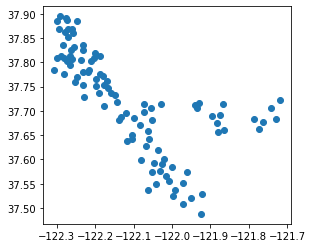

In [3]:
# Pull in polling location
polling_ac_df = pd.read_csv('notebook_data/ac_voting_locations.csv')
polling_ac_df.head()

# Make into geo data frame
polling_ac_gdf = gpd.GeoDataFrame(polling_ac_df, 
                               geometry=gpd.points_from_xy(polling_ac_df.X, polling_ac_df.Y))
polling_ac_gdf.crs = "epsg:4326"

polling_ac_gdf.plot()

## 15.2 Census tracts
We'll also bring in our census tracts data for Alameda county.

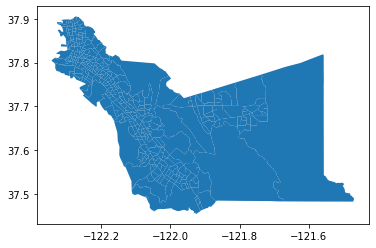

In [4]:
# Bring in census tracts
tracts_gdf = gpd.read_file("zip://notebook_data/census/Tracts/cb_2013_06_tract_500k.zip")

# Narrow it down to Alameda County
tracts_gdf_ac = tracts_gdf[tracts_gdf['COUNTYFP']=='001']
tracts_gdf_ac.plot()
plt.show()

To make sure we can use it with our polling locations data, we'll check the Coordinate Reference System (CRS).

In [5]:
# Check CRS
print('polling_ac_gdf:', polling_ac_gdf.crs)
print('tracts_gdf_ac CRS:', tracts_gdf_ac.crs)

polling_ac_gdf: epsg:4326
tracts_gdf_ac CRS: epsg:4269


Uh oh! It looks like they have different CRS. We'll transform them both
> Note: If you need a refresher on CRS check out Lesson 3, Coordinate Reference Systems (CRS) & Map Projections

In [6]:
# Transform CRS
polling_ac_gdf_utm10 = polling_ac_gdf.to_crs("epsg:26910")
tracts_gdf_ac_utm10 = tracts_gdf_ac.to_crs("epsg:26910")

And now let's plot them together to see how the polling locations are spread across the county.

<AxesSubplot:>

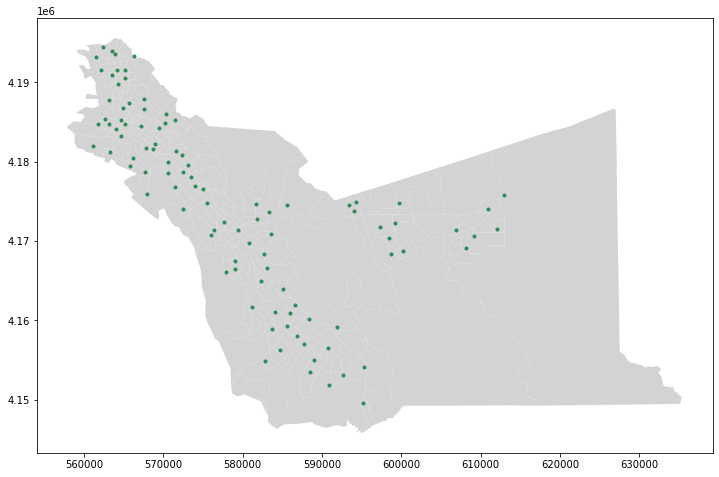

In [12]:
fig, ax = plt.subplots(figsize = (14,8)) 

tracts_gdf_ac_utm10.plot(ax=ax,color='lightgrey',
                         legend=True)
polling_ac_gdf_utm10.plot(ax=ax, color='seagreen', markersize=9)

## 15.3 Voronoi Tessellation

To make our Voronoi geometries, we'll be using the `voronoi_regions_from_coords` from the `geovoronai` package. Let's check the helper function.

In [14]:
?voronoi_regions_from_coords

You'll see that the helper function says *enerate Voronoi regions from NumPy array of 2D coordinates or list of Shapely Point objects in `coord`*. That means instead of GeoDataframe as an input, we'll need to first convert all our geometries to numpy arrays. 

We can easily do this by using `points_to_coords`

In [16]:
polling_array = points_to_coords(polling_ac_gdf_utm10.geometry)

And now we're ready to run our voronoi region creation! We put in two inputs: our polling locations as a numpy array and our tracts boundary (which we created using `unary_union`).

In [18]:
region_polys, region_pts = voronoi_regions_from_coords(polling_array, tracts_gdf_ac_utm10.unary_union)

You'll also notice we get two outputs from our line of code. The first object, in our case `region_polys` gives us the shape of the Voronoi geometry, while `region_pts` gives us the list of points.

To easily plot our points, we can use the `plot_voronoi_polys_with_points_in_area` which takes the following arguments:
- `ax`: Matplotlib axes object on which you want to plot
- `area_shape`: the boundary shape that encompasses our Voronoi regions. In our case this is the shape of Alameda County.
- `region_polys`: The dictionary that we got from above that gives the IDs and the polygons of our Voronoi geoemtries.
- `points`: The numpy array of our shapely point objects, which we got above as `region_pts`

There are more arguments than this that you can use to customize your plot. Uncomment the code below to see the helper file.

In [19]:
# ?plot_voronoi_polys_with_points_in_area

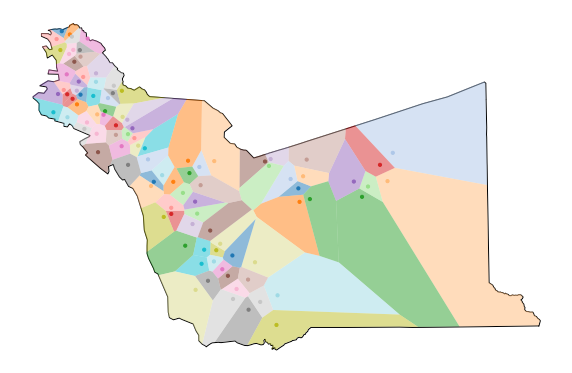

In [23]:
fig, ax =  subplot_for_map(figsize=(10,10))
plot_voronoi_polys_with_points_in_area(ax, tracts_gdf_ac_utm10.unary_union, 
                                       region_polys, 
                                       polling_array, 
                                       region_pts,
                                       points_markersize=10)

Ta-da!!!! 

## 15.4 Voronoi colored by an attribute

Now we can go a step beyond this by changing the colors of each of our Voronoi regions based on a certain attribute.

To do that, let's first get all of our region geometries as a list.

In [28]:
list_polys = list(region_polys.values())
list_polys[0:5]

And we'll replace our point geometries in our original polling locations geodataframe.

<AxesSubplot:>

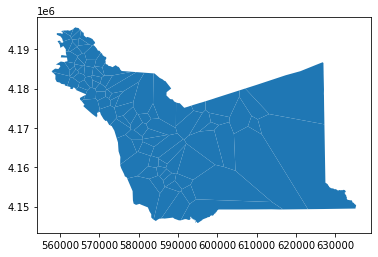

In [30]:
polling_v = gpd.GeoDataFrame(polling_ac_gdf_utm10.drop('geometry',axis=1),
                                  geometry=list_polys)
polling_v.plot()

Say we had a number of votes cast count for every polling location. We'll randomly generate it here...

In [34]:
polling_v['votes_cast'] = random.sample(range(10000,50000), polling_v.shape[0])

And we can now color our polygons based on the number of votes cast there.

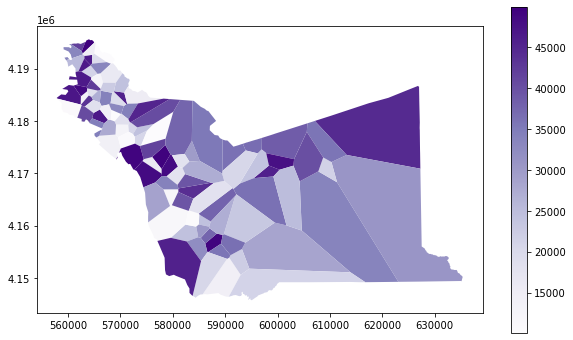

In [44]:
fig, ax= plt.subplots(figsize=(10,6))
polling_v.plot(column='votes_cast', cmap='Purples', legend=True, ax=ax)
plt.show()

---
<div style="display:inline-block;vertical-align:middle;">
<a href="https://dlab.berkeley.edu/" target="_blank"><img src ="assets/images/dlab_logo.png" width="75" align="left">
</a>
</div>

<div style="display:inline-block;vertical-align:middle;">
    <div style="font-size:larger">&nbsp;D-Lab @ University of California - Berkeley</div>
    <div>&nbsp;Team Geo<div>
</div>
        



